<a href="https://colab.research.google.com/github/Hugues-PETITJEAN/Network-In-Silico-Drug-Research/blob/main/AIS_connectivity2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# intallation specifique pour colab
!pip install brian2
!pip install brian2tools
!pip install --upgrade neurodynex3
!pip install plot-utils

In [ ]:
import brian2
print(brian2.__version__)

2.3


In [ ]:
# mettre a jour brian2 a la v 2.5
#pip install -U brian2
#import brian2
#print(brian2.__version__)


In [ ]:
from brian2 import *
import cython
import numpy
import matplotlib as plt
import plot_utils as pu
#deux librairie de graph
%matplotlib inline
import brian2tools
import neurodynex3
print (cython.__version__)
print (numpy.__version__)

0.29.24
1.19.5


In [ ]:
prefs.codegen.target = 'cython'  # use the Python fallback


In [ ]:
probavalue = [1, 0]
def selectRandom(probavalue):
  return numpy.random.choice(probavalue)
print (selectRandom(probavalue))

1


In [ ]:
start_scope()
device.reinit()
device.activate()
set_device('cpp_standalone', build_on_run=False)  # Use fast "C++ standalone mode"

################################################################################
# Model parameters
################################################################################
### General parameters
duration = 150*second       # Total simulation time
sim_dt = 50*ms               # Integrator/sampling step



### Astrocyte parameters
# ---  Calcium fluxes
O_P = 0.9*umolar/second      # Maximal Ca^2+ uptake rate by SERCAs
K_P = 0.05 * umolar          # Ca2+ affinity of SERCAs
C_T = 2*umolar               # Total cell free Ca^2+ content
rho_A = 0.18                 # ER-to-cytoplasm volume ratio
Omega_C = 6/second           # Maximal rate of Ca^2+ release by IP_3Rs
Omega_L = 0.1/second         # Maximal rate of Ca^2+ leak from the ER
# --- IP_3R kinectics
d_1 = 0.13*umolar            # IP_3 binding affinity
d_2 = 1.05*umolar            # Ca^2+ inactivation dissociation constant
O_2 = 0.2/umolar/second      # IP_3R binding rate for Ca^2+ inhibition
d_3 = 0.9434*umolar          # IP_3 dissociation constant
d_5 = 0.08*umolar            # Ca^2+ activation dissociation constant
# --- IP_3 production
O_delta = 0.6*umolar/second  # Maximal rate of IP_3 production by PLCdelta
kappa_delta = 1.5* umolar    # Inhibition constant of PLC_delta by IP_3
K_delta = 0.1*umolar         # Ca^2+ affinity of PLCdelta
# --- IP_3 degradation
Omega_5P = 0.05/second       # Maximal rate of IP_3 degradation by IP-5P
K_D = 0.7*umolar             # Ca^2+ affinity of IP3-3K
K_3K = 1.0*umolar            # IP_3 affinity of IP_3-3K
O_3K = 4.5*umolar/second     # Maximal rate of IP_3 degradation by IP_3-3K
# --- IP_3 diffusion
F_ex = 0.09*umolar/second    # Maximal exogenous IP3 flow
F = 0.09*umolar/second       # GJC IP_3 permeability
I_Theta = 0.3*umolar         # Threshold gradient for IP_3 diffusion
omega_I = 0.05*umolar        # Scaling factor of diffusion

################################################################################
# Model definition
################################################################################
defaultclock.dt = sim_dt     # Set the integration time

### Astrocytes
astro_eqs = '''
dI/dt = J_delta - J_3K - J_5P + J_ex + J_coupling : mmolar
J_delta = O_delta/(1 + I/kappa_delta) * C**2/(C**2 + K_delta**2) : mmolar/second
J_3K = O_3K * C**4/(C**4 + K_D**4) * I/(I + K_3K)                : mmolar/second
J_5P = Omega_5P*I                                                : mmolar/second
# Exogenous stimulation (rectangular wave with period of 50s and duty factor 0.4)
#stimulus = int((t % (50*second))<20*second)                      : 1
stimulus = 1   :1
#stimulus =  int(selectRandom(probavalue)) :1
delta_I_bias = I - I_bias*stimulus                               : mmolar
J_ex = -F_ex/2*(1 + tanh((abs(delta_I_bias) - I_Theta)/omega_I)) *
                sign(delta_I_bias)                               : mmolar/second
# Diffusion between astrocytes
J_coupling : mmolar/second

# Ca^2+-induced Ca^2+ release:
dC/dt = J_r + J_l - J_p                                   : mmolar
dh/dt = (h_inf - h)/tau_h                                 : 1
J_r = (Omega_C * m_inf**3 * h**3) * (C_T - (1 + rho_A)*C) : mmolar/second
J_l = Omega_L * (C_T - (1 + rho_A)*C)                     : mmolar/second
J_p = O_P * C**2/(C**2 + K_P**2)                          : mmolar/second
m_inf = I/(I + d_1) * C/(C + d_5)                         : 1
h_inf = Q_2/(Q_2 + C)                                     : 1
tau_h = 1/(O_2 * (Q_2 + C))                               : second
Q_2 = d_2 * (I + d_1)/(I + d_3)                           : mmolar

# External IP_3 drive
I_bias : mmolar (constant)
'''
#creation d un indices pour choisir une liste d astro a stri
#indices = array([N_astro//2-1])
N_astro = 80 # Total number of astrocytes in the network
astrocytes = NeuronGroup(N_astro, astro_eqs, method='rk4')
# Asymmetric stimulation on INDICES cell to get some nice chaotic patterns
astrocytes.I_bias = 1.0*umolar
astrocytes.h = 0.9
# Diffusion between astrocytes
astro_to_astro_eqs = '''
delta_I = I_post - I_pre        : mmolar
J_coupling_post = -F/2 * (1 + tanh((abs(delta_I) - I_Theta)/omega_I)) *
                  sign(delta_I) : mmolar/second (summed)
'''
### Astrocytes2
astro_eqs2 = '''
dI/dt = J_delta - J_3K - J_5P + J_ex + J_coupling + J_coupling2 : mmolar
J_delta = O_delta/(1 + I/kappa_delta) * C**2/(C**2 + K_delta**2) : mmolar/second
J_3K = O_3K * C**4/(C**4 + K_D**4) * I/(I + K_3K)                : mmolar/second
J_5P = Omega_5P*I                                                : mmolar/second
# Exogenous stimulation (rectangular wave with period of 50s and duty factor 0.4)
#stimulus = int((t % (50*second))<20*second)                      : 1
stimulus = 0   :1
#stimulus =  int(selectRandom(probavalue)) :1
delta_I_bias = I - I_bias*stimulus                               : mmolar
J_ex = -F_ex/2*(1 + tanh((abs(delta_I_bias) - I_Theta)/omega_I)) *
                sign(delta_I_bias)                               : mmolar/second
# Diffusion between astrocytes
J_coupling : mmolar/second
J_coupling2: mmolar/second

# Ca^2+-induced Ca^2+ release:
dC/dt = J_r + J_l - J_p                                   : mmolar
dh/dt = (h_inf - h)/tau_h                                 : 1
J_r = (Omega_C * m_inf**3 * h**3) * (C_T - (1 + rho_A)*C) : mmolar/second
J_l = Omega_L * (C_T - (1 + rho_A)*C)                     : mmolar/second
J_p = O_P * C**2/(C**2 + K_P**2)                          : mmolar/second
m_inf = I/(I + d_1) * C/(C + d_5)                         : 1
h_inf = Q_2/(Q_2 + C)                                     : 1
tau_h = 1/(O_2 * (Q_2 + C))                               : second
Q_2 = d_2 * (I + d_1)/(I + d_3)                           : mmolar

# External IP_3 drive
I_bias : mmolar (constant)
'''

astrocytes2 = NeuronGroup(80, astro_eqs2,method='rk4')



astrocytes2.I_bias = 1.0*umolar
astrocytes2.h = 0.9
# Diffusion between astrocytes
astro_to_astro_eqs = '''
delta_I = I_post - I_pre        : mmolar
J_coupling_post = -F/2 * (1 + tanh((abs(delta_I) - I_Theta)/omega_I)) *
                  sign(delta_I) : mmolar/second (summed)
'''

#connection entre les astro
#astrocytes = OTR+
#astrocyte2= OTR-

astro_to_astro = Synapses(astrocytes, astrocytes2,
                          model=astro_to_astro_eqs)

#astro_to_astro.connect(condition='i!=j', p=0.05)
#small world need 80 astro
astro_to_astro.connect(j='k for k in range(i, i+4) if i% 4 ==0',skip_if_invalid=True)


astro_to_astro_eqs2 = '''
delta_I = I_post - I_pre        : mmolar
J_coupling2_post = -F/2 * (1 + tanh((abs(delta_I) - I_Theta)/omega_I)) *
                  sign(delta_I) : mmolar/second (summed)
'''

astro_to_astro2 = Synapses(astrocytes2, astrocytes2,
                          model=astro_to_astro_eqs2)
astro_to_astro2.connect(condition='i!=j', p=0.01)

astro_to_astro_eqs3 = '''
delta_I = I_post - I_pre        : mmolar
J_coupling_post = -F/2 * (1 + tanh((abs(delta_I) - I_Theta)/omega_I)) *
                  sign(delta_I) : mmolar/second (summed)
'''
astro_to_astro3 = Synapses(astrocytes2, astrocytes,
                          model=astro_to_astro_eqs3)
astro_to_astro3.connect(j='k for k in range(i, i+4) if i% 4 ==0',skip_if_invalid=True)

################################################################################
# Monitors
################################################################################
astro_mon = StateMonitor(astrocytes, variables=['C'], record=True)
astro_mon2 = StateMonitor(astrocytes2, variables=['C'], record=True)
################################################################################
# Simulation run
################################################################################
run(duration, report='text')

device.build(directory='output', compile=True, run=True, debug=False)



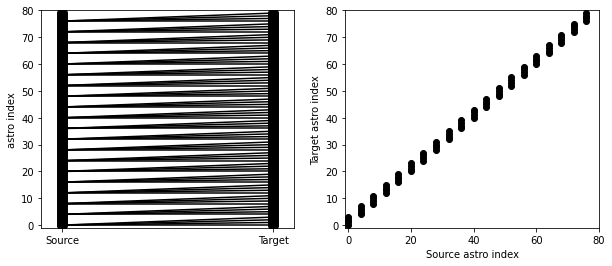

In [ ]:
#astro_to_astro
#visualisation de la connectivite
def visualise_connectivity(astro_to_astro):
    Ns = len(astro_to_astro.source)
    Nt = len(astro_to_astro.target)
    figure(figsize=(10, 4))
    subplot(121)
    plot(zeros(Ns), arange(Ns), 'ok', ms=10)
    plot(ones(Nt), arange(Nt), 'ok', ms=10)
    for i, j in zip(astro_to_astro.i, astro_to_astro.j):
        plot([0, 1], [i, j], '-k')
    xticks([0, 1], ['Source', 'Target'])
    ylabel('astro index')
    xlim(-0.1, 1.1)
    ylim(-1, max(Ns, Nt))
    subplot(122)
    plot(astro_to_astro.i, astro_to_astro.j, 'ok')
    xlim(-1, Ns)
    ylim(-1, Nt)
    xlabel('Source astro index')
    ylabel('Target astro index')

visualise_connectivity(astro_to_astro)

In [ ]:
#astro_to_astro
#visualisation de la connectivite
def visualise_connectivity(astro_to_astro2):
    Ns = len(astro_to_astro2.source)
    Nt = len(astro_to_astro2.target)
    figure(figsize=(10, 4))
    subplot(121)
    plot(zeros(Ns), arange(Ns), 'ok', ms=10)
    plot(ones(Nt), arange(Nt), 'ok', ms=10)
    for i, j in zip(astro_to_astro2.i, astro_to_astro2.j):
        plot([0, 1], [i, j], '-k')
    xticks([0, 1], ['Source', 'Target'])
    ylabel('astro index')
    xlim(-0.1, 1.1)
    ylim(-1, max(Ns, Nt))
    subplot(122)
    plot(astro_to_astro2.i, astro_to_astro2.j, 'ok')
    xlim(-1, Ns)
    ylim(-1, Nt)
    xlabel('Source astro index')
    ylabel('Target astro index')

visualise_connectivity(astro_to_astro2)

In [ ]:
################################################################################
# Analysis and plotting
################################################################################
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6.26894, 6.26894 * 0.66),
                       gridspec_kw={'left': 0.1, 'bottom': 0.12})
scaling = 1.2
step = 10
ax.plot(astro_mon.t/second,
        (astro_mon.C[0:N_astro//2-1].T/astro_mon.C.max() +
         np.arange(N_astro//2-1)*scaling), color='C1')
ax.plot(astro_mon.t/second, (astro_mon.C[N_astro//2:].T/astro_mon.C.max() +
                             np.arange(N_astro//2, N_astro)*scaling),
        color='C1')
ax.plot(astro_mon.t/second, (astro_mon.C[N_astro//2-1].T/astro_mon.C.max() +
                             np.arange(N_astro//2-1, N_astro//2)*scaling),
        color='C1')
ax.set(xlim=(0., duration/second), ylim=(0, (N_astro+1.5)*scaling),
       xticks=numpy.arange(0., duration/second, 500), xlabel='time (s)',
       yticks=numpy.arange(0.5*scaling, (N_astro + 1.5)*scaling, step*scaling),
       yticklabels=[str(yt) for yt in numpy.arange(0, N_astro + 1, step)],
       ylabel='$C/C_{max}$ (cell index)')

plt.show()

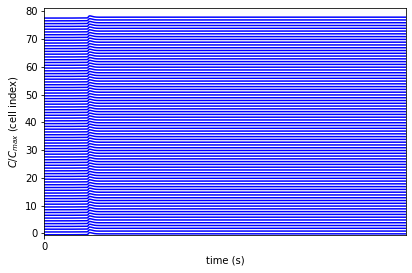

In [ ]:
################################################################################
# Analysis and plotting
################################################################################
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6.26894, 6.26894 * 0.66),
                       gridspec_kw={'left': 0.1, 'bottom': 0.12})
scaling = 1.2
step = 10
ax.plot(astro_mon2.t/second,(astro_mon2.C[0:79].T/astro_mon.C.max() + np.arange(79)*scaling), color='blue')

ax.set(xlim=(0., duration/second), ylim=(0, (80+1.5)*scaling),
       xticks=numpy.arange(0., duration/second, 500), xlabel='time (s)',
       yticks=numpy.arange(0.5*scaling, (80 + 1.5)*scaling, step*scaling),
       yticklabels=[str(yt) for yt in numpy.arange(0, 80 + 1, step)],
       ylabel='$C/C_{max}$ (cell index)')

plt.show()

In [ ]:
# donne tout les points de mesures
Alldata = astro_mon2.get_states()
Alldata['C']

array([[  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  9.42311278,   9.42311278,   9.42311278, ...,   9.42311278,
          9.42311278,   9.42311278],
       [ 16.38322442,  16.38322442,  16.38322442, ...,  16.38322442,
         16.38322442,  16.38322442],
       ...,
       [396.16454888, 396.16454888, 396.16454888, ..., 396.16454888,
        396.16454888, 396.16454888],
       [396.79633426, 396.79633426, 396.79633426, ..., 396.79633426,
        396.79633426, 396.79633426],
       [397.45297229, 397.45297229, 397.45297229, ..., 397.45297229,
        397.45297229, 397.45297229]]) * nmolar

In [ ]:
import pandas as pd
df6 = pd.DataFrame(data=Alldata['C'])

In [ ]:
df6.describe()

0            1   ...           78           79
count  3000.000000  3000.000000  ...  3000.000000  3000.000000
mean      0.000368     0.000368  ...     0.000368     0.000368
std       0.000133     0.000133  ...     0.000133     0.000133
min       0.000000     0.000000  ...     0.000000     0.000000
25%       0.000393     0.000393  ...     0.000393     0.000393
50%       0.000403     0.000403  ...     0.000403     0.000403
75%       0.000416     0.000416  ...     0.000416     0.000416
max       0.000956     0.000956  ...     0.000956     0.000956

[8 rows x 80 columns]

In [ ]:
from google.colab import drive
drive.mount('drive')

In [ ]:
file_name = 'DataHP.xlsx'

# saving the excel
df6.to_excel(file_name)

In [ ]:
import pandas
df6.to_excel(r'drive/My Drive/datafromcolab.xlsx', index = False)